# Integrate with Torch

Inspiration from https://earthmover.io/blog/cloud-native-dataloader/
But I'm not sure we want to use xbatcher?

### TODO

1. should check that num_surface_vars, num_atmospheric_vars, and num_outputs all makes sense... probably in the sense of the channels... during init?
2. in `__call__`:
    * basically don't need to do anything for inputs to grid node features... probably just the xarray_jax call
    * grid_node_outputs_to_prediction ... just do up to the reshape call
3. `_maybe_init`: just pass lats and lons instead of sample inputs
4. `loss_and_predictions`:
    * could transform to xr.dataarray and then rewrite nothing
    * this would skip over the `level` specific weighting
    * and will have to avoid the `sum_per_variable_losses` since we don't have variables
    * next level of simplicity would be to inflate targets and predictions to their usual sizes and hookup as is. could do this by passing a template to the initialization and just always carry that around... but worry would be that this is somehow problematic
  
...
next up is Bfloat16cast, normalize, and inputsandresiduals

### Deemed out of scope

Here be a list of stuff deemed out of scope while initially figuring this out

1. weighted loss by variable. We will want to just create an array like normalization to be applied, or we could channel idx:val mapping. 
2. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as TorchDataLoader
from torch.utils.data import Dataset as TorchDataset
from xbatcher import BatchGenerator

In [2]:
from simple_emulator import P0Emulator

In [3]:
from graphcast.stacked_graphcast import StackedGraphCast

In [4]:
from graphcast.data_utils import extract_inputs_targets_forcings
from graphcast.model_utils import lat_lon_to_leading_axes, dataset_to_stacked
from graphcast.xarray_jax import unwrap
import dataclasses

class GraphUFSDataset():

    @property
    def xds(self):
        return self.sample_generator.ds

    def __init__(
        self,
        emulator,
        mode,
    ):

        self.emulator = emulator
        self.mode = mode
        xds = self._open_dataset()
        self.sample_generator = BatchGenerator(
            ds=xds,
            input_dims={
                "datetime": emulator.n_forecast,
                "lon": len(xds["lon"]),
                "lat": len(xds["lat"]),
                "level": len(xds["level"]),
            },
            # adding batch_dims does nothing
            input_overlap={
                "time": emulator.n_input,
            },
            preload_batch=False,
        )

    
    def __len__(self):
        return len(self.sample_generator)

    
    def __getitem__(self, idx): # returns dict with inputs targets forcings
        sample_input, sample_target, sample_forcing = self.get_xarrays(idx)

        X = self._stack(sample_input, sample_forcing)
        y = self._stack(sample_target)
        return X, y

    @staticmethod
    def _xstack(a, b=None):
        """results in array with shape [lat, lon, batch, channels] which is the easiest shape to work with
        other than a totally flat array, because the StackedGraphCast has to reshape everything
        from a flat array, and this lat_lon_leading shape requires no assumptions regarding number of dimensions

        Returns:
            result (xarray.DataArray): 
        """
        result = dataset_to_stacked(a)
        if b is not None:
            result = xr.concat(
                [result, dataset_to_stacked(b)],
                dim="channels",
            )
        result = lat_lon_to_leading_axes(result)
        return result

    def _stack(self, a, b=None):
        """same thing as xstack, but unpack data from xarray

        Returns:
            result (chex.Array)
        """
        xresult = self._xstack(a, b)
        return xresult.data

    def _open_dataset(self):

        xds = self.emulator.open_dataset()
        time = self.emulator.get_time(mode=self.mode)
        xds = self.emulator.subsample_dataset(xds, new_time=time)
        xds = xds.rename({
            "time": "datetime",
            "pfull": "level",
            "grid_yt": "lat",
            "grid_xt": "lon",
        })
        xds = xds.drop_vars(["cftime", "ftime"])
        return xds


    def _preprocess(self, xds):
        xds["time"] = xds["datetime"] - xds["datetime"][0]
        xds = xds.swap_dims({"datetime": "time"}).reset_coords()
        xds = xds.set_coords(["datetime"])
        return xds

    def get_xda(self, idx : int):
        sample = self.sample_generator[idx]
        sample = self._preprocess(sample)
        sample = sample.load()
        return sample

    def get_xarrays(self, idx : int):
        sample = self.get_xda(idx)

        kw = {k:v for k,v in dataclasses.asdict(self.emulator.task_config).items() if k not in ("latitude", "longitude")}
        
        sample_input, sample_target, sample_forcing = extract_inputs_targets_forcings(
            sample,
            target_lead_times=self.emulator.target_lead_time,
            **kw,
        )
        sample_input = sample_input.expand_dims({"batch": [idx]})
        sample_target = sample_target.expand_dims({"batch": [idx]})
        sample_forcing = sample_forcing.expand_dims({"batch": [idx]})
        return sample_input, sample_target, sample_forcing

    def get_xsample(self, idx : int):
        sample_input, sample_target, sample_forcing = self.get_xarrays(idx)

        X = self._xstack(sample_input, sample_forcing)
        y = self._xstack(sample_target)
        return X, y

## Do the work

Note that `BatchGenerator` should really be a `SampleGenerator` in this case ... it doesn't actually batch things!

In [5]:
p0 = P0Emulator()

In [6]:
from p1 import P1Emulator

In [7]:
p1 = P1Emulator()

In [8]:
%%time
training_data = GraphUFSDataset(p1, mode="training")

CPU times: user 11.4 s, sys: 1.68 s, total: 13.1 s
Wall time: 14.3 s


In [10]:
%%time
training_data[0]

CPU times: user 2.75 s, sys: 508 ms, total: 3.25 s
Wall time: 2.97 s


(array([[[[ 1.1924881e-08,  7.0710701e-01, -1.0000000e+00, ...,
            2.0000000e+00,  9.9999481e-01,  3.2244858e-03]],
 
         [[ 1.6361948e-02,  7.1858168e-01, -9.9986613e-01, ...,
            2.0000000e+00,  9.9999481e-01,  3.2244858e-03]],
 
         [[ 3.2719027e-02,  7.2986424e-01, -9.9946457e-01, ...,
            2.0000000e+00,  9.9999481e-01,  3.2244858e-03]],
 
         ...,
 
         [[-4.9067326e-02,  6.7155910e-01, -9.9879545e-01, ...,
            2.0000000e+00,  9.9999481e-01,  3.2244858e-03]],
 
         [[-3.2719005e-02,  6.8359256e-01, -9.9946457e-01, ...,
            2.0000000e+00,  9.9999481e-01,  3.2244858e-03]],
 
         [[-1.6361926e-02,  6.9544274e-01, -9.9986613e-01, ...,
            2.0000000e+00,  9.9999481e-01,  3.2244858e-03]]],
 
 
        [[[ 1.1924881e-08,  7.0710701e-01, -1.0000000e+00, ...,
            2.0000000e+00,  9.9999481e-01,  3.2244858e-03]],
 
         [[ 1.6361948e-02,  7.1858168e-01, -9.9986613e-01, ...,
            2.0000000e+00,  

In [11]:
x, y = training_data.get_xsample(40)

In [12]:
x

<xarray.DataArray (lat: 192, lon: 384, batch: 1, channels: 187)> Size: 55MB
array([[[[ 1.1924881e-08,  7.0710701e-01, -1.0000000e+00, ...,
           2.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[ 1.6361948e-02,  7.1858168e-01, -9.9986613e-01, ...,
           2.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[ 3.2719027e-02,  7.2986424e-01, -9.9946457e-01, ...,
           2.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        ...,

        [[-4.9067326e-02,  6.7155910e-01, -9.9879545e-01, ...,
           2.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[-3.2719005e-02,  6.8359256e-01, -9.9946457e-01, ...,
           2.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[-1.6361926e-02,  6.9544274e-01, -9.9986613e-01, ...,
           2.0000000e+00,  9.6606368e-01,  2.5830415e-01]]],

...
       [[[ 1.1924881e-08,  7.0710701e-01, -1.0000000e+00, ...,
           1.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[ 1.6361948e-02,  7.1858168e-01, -9.9986613e-01, ...,
           1.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[ 3.2719027e-02,  7.2986424e-01, -9.9946457e-01, ...,
           1.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        ...,

        [[-4.9067326e-02,  6.7155910e-01, -9.9879545e-01, ...,
           1.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[-3.2719005e-02,  6.8359256e-01, -9.9946457e-01, ...,
           1.0000000e+00,  9.6606368e-01,  2.5830415e-01]],

        [[-1.6361926e-02,  6.9544274e-01, -9.9986613e-01, ...,
           1.0000000e+00,  9.6606368e-01,  2.5830415e-01]]]],
      dtype=float32)
Coordinates:
  * batch    (batch) int64 8B 40
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
Dimensions without coordinates: channels

In [13]:
chunks = {
    "lat": -1,
    "lon": -1,
    "batch": 1,
    "channels": -1,
}

In [14]:
x.chunk(chunks)

<xarray.DataArray (lat: 192, lon: 384, batch: 1, channels: 187)> Size: 55MB
dask.array<xarray-<this-array>, shape=(192, 384, 1, 187), dtype=float32, chunksize=(192, 384, 1, 187), chunktype=numpy.ndarray>
Coordinates:
  * batch    (batch) int64 8B 40
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
Dimensions without coordinates: channels

In [15]:
y.chunk(chunks)

<xarray.DataArray (lat: 192, lon: 384, batch: 1, channels: 83)> Size: 24MB
dask.array<xarray-<this-array>, shape=(192, 384, 1, 83), dtype=float32, chunksize=(192, 384, 1, 83), chunktype=numpy.ndarray>
Coordinates:
  * batch    (batch) int64 8B 40
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
Dimensions without coordinates: channels
Attributes:
    cell_methods:               time: point
    long_name:                  height thickness
    max_abs_compression_error:  0.0943603515625
    nbits:                      14
    output_file:                dyn
    units:                      m

In [17]:
len(training_data)

25323

In [18]:
sds = xr.Dataset()

In [19]:
ids = x.to_dataset(name="inputs")
tds = y.to_dataset(name="targets")

In [20]:
ids.to_zarr("inputs.zarr", mode="w")
tds.to_zarr("targets.zarr", mode="w")

In [21]:
42 * len(training_data)

1063566

In [22]:
20 * len(training_data)

506460

In [7]:
%%time
x, y = training_data[40]

X.shape, y.shape (192, 384, 1, 25) (192, 384, 1, 6)
CPU times: user 300 ms, sys: 118 ms, total: 418 ms
Wall time: 720 ms


In [8]:
inputs,targets,forcings = training_data.get_xarrays(40)


In [9]:
import haiku as hk
import jax
from graphcast.graphcast import GraphCast

In [10]:
@hk.transform_with_state
def run_original(emulator, inputs, targets, forcings):
    predictor = GraphCast(emulator.model_config, emulator.task_config)
    return predictor(inputs, targets, forcings)

In [11]:
init2 = jax.jit(run_original.init)

In [12]:
params_og, state_og = init2(
    rng=jax.random.PRNGKey(0),
    emulator=p0,
    inputs=inputs,
    targets=targets,
    forcings=forcings,
)

In [13]:
gc = jax.jit(run_original.apply)

In [14]:
expected, _ = gc(
    rng=jax.random.PRNGKey(0),
    emulator=p0,
    inputs=inputs,
    targets=targets,
    forcings=forcings,
    params=params_og,
    state=state_og,
)
expected = dataset_to_stacked(expected)
expected = expected.squeeze()

In [15]:
@hk.transform_with_state
def run_forward(emulator, x_i):
    predictor = StackedGraphCast(emulator.model_config, emulator.task_config)
    return predictor(x_i)

In [16]:
init = jax.jit(run_forward.init)

In [17]:
params, state = init(
    rng=jax.random.PRNGKey(0),
    emulator=p0,
    x_i=x,
)

In [18]:
f = jax.jit(run_forward.apply)

In [19]:
test, _ = f(emulator=p0, x_i=x, params=params, state=state, rng=jax.random.PRNGKey(0))
test = test.squeeze()

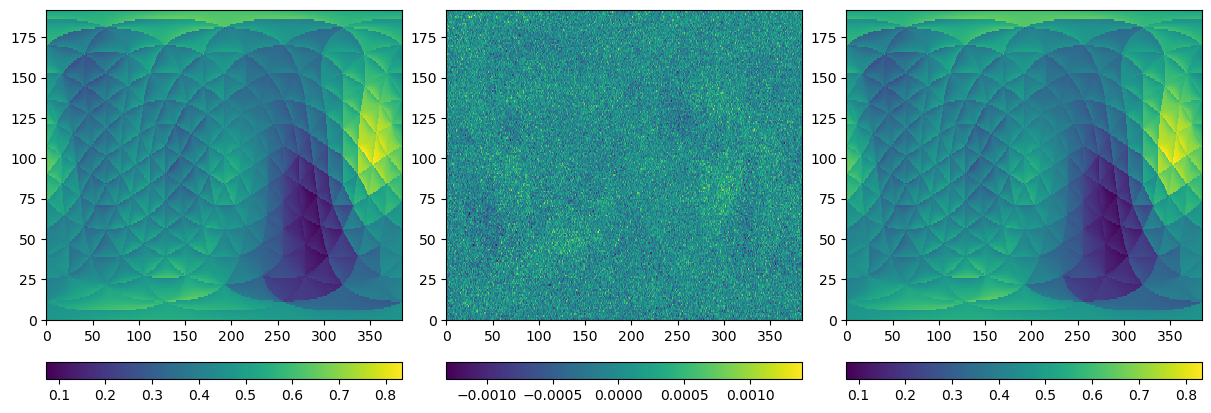

In [20]:
fig, axs = plt.subplots(1,3, figsize=(12, 4), constrained_layout=True)

ii = 4
p = axs[0].pcolormesh(test[:,:,ii])
plt.colorbar(p, ax=axs[0],orientation="horizontal")
p = axs[1].pcolormesh(test[:,:,ii] - expected[..., ii])
plt.colorbar(p, ax=axs[1],orientation="horizontal")
p = axs[2].pcolormesh(expected[...,ii])
plt.colorbar(p, ax=axs[2],orientation="horizontal")

In [22]:
(np.abs(test - expected)/np.abs(expected)).max().values

array(396.7507, dtype=float32)

In [23]:
(np.abs(test - expected)).max().values

array(0.00161451, dtype=float32)

In [18]:
si = s["inputs"]

In [19]:
from graphcast.model_utils import stacked_to_dataset, dataset_to_stacked
from graphufs.utils import normalization_to_stacked

In [20]:
m = p0.norm["mean"]

In [21]:
m

<xarray.Dataset> Size: 72B
Dimensions:            (level: 3)
Coordinates:
  * level              (level) float32 12B 97.82 505.7 998.8
Data variables:
    year_progress_cos  float64 8B 0.01172
    pressfc            float32 4B 9.667e+04
    tmp                (level) float32 12B 207.9 252.1 278.6
    vgrd10m            float32 4B 0.1846
    year_progress_sin  float64 8B -0.001923
    day_progress_sin   float64 8B -1.023e-08
    land               float32 4B 0.6985
    day_progress_cos   float64 8B 2.679e-08
    ugrd10m            float32 4B -0.03665

In [22]:
sm = normalization_to_stacked(p0, m, preserved_dims=())

In [23]:
sm

<xarray.DataArray (channels: 15)> Size: 120B
array([ 2.67949266e-08, -1.02316133e-08,  9.66684609e+04,  2.07933472e+02,
        2.52135315e+02,  2.78622650e+02, -3.66467498e-02,  1.84575677e-01,
        1.17212740e-02, -1.92328226e-03,  2.67949266e-08, -1.02316133e-08,
        6.98509097e-01,  1.17212740e-02, -1.92328226e-03])
Dimensions without coordinates: channels

In [24]:
ssi = dataset_to_stacked(si, preserved_dims=("time", "lat", "lon"))

In [25]:
p0.task_config.input_variables

('pressfc',
 'ugrd10m',
 'vgrd10m',
 'tmp',
 'year_progress_sin',
 'year_progress_cos',
 'day_progress_sin',
 'day_progress_cos')

In [26]:
ssi

<xarray.DataArray (time: 2, lat: 192, lon: 384, channels: 10)> Size: 6MB
array([[[[-1.00000000e+00, -8.74227766e-08,  1.03288617e+05, ...,
          -3.53801560e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03287914e+05, ...,
          -3.47437239e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03287203e+05, ...,
          -3.40974498e+00,  9.24799800e-01,  3.80454123e-01],
         ...,
         [-9.98795450e-01,  4.90674898e-02,  1.03291070e+05, ...,
          -3.72292423e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01,  3.27191688e-02,  1.03290234e+05, ...,
          -3.66230249e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01,  1.63616110e-02,  1.03289391e+05, ...,
          -3.60066247e+00,  9.24799800e-01,  3.80454123e-01]],

        [[-1.00000000e+00, -8.74227766e-08,  1.03066438e+05, ...,
          -3.86410904e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03065023e+05, ...,
          -3.81059551e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03063734e+05, ...,
          -3.75581288e+00,  9.24799800e-01,  3.80454123e-01],
...
           1.41469872e+00,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  7.03043125e+04, ...,
           1.34412932e+00,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  7.02729141e+04, ...,
           1.27389371e+00,  9.23155010e-01,  3.84427905e-01]],

        [[ 1.19248806e-08, -1.00000000e+00,  6.93757344e+04, ...,
           7.07737386e-01,  9.23155010e-01,  3.84427905e-01],
         [ 1.63619481e-02, -9.99866128e-01,  6.93617578e+04, ...,
           6.45593286e-01,  9.23155010e-01,  3.84427905e-01],
         [ 3.27190273e-02, -9.99464571e-01,  6.93475859e+04, ...,
           5.83316505e-01,  9.23155010e-01,  3.84427905e-01],
         ...,
         [-4.90673259e-02, -9.98795450e-01,  6.94166406e+04, ...,
           8.93158257e-01,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  6.94031719e+04, ...,
           8.31541300e-01,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  6.93895312e+04, ...,
           7.69727170e-01,  9.23155010e-01,  3.84427905e-01]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * time     (time) timedelta64[ns] 16B -1 days +18:00:00 00:00:00
Dimensions without coordinates: channels

In [27]:
ssf = dataset_to_stacked(s["forcings"], preserved_dims=("time", "lat", "lon"))

In [28]:
ssi

<xarray.DataArray (time: 2, lat: 192, lon: 384, channels: 10)> Size: 6MB
array([[[[-1.00000000e+00, -8.74227766e-08,  1.03288617e+05, ...,
          -3.53801560e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03287914e+05, ...,
          -3.47437239e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03287203e+05, ...,
          -3.40974498e+00,  9.24799800e-01,  3.80454123e-01],
         ...,
         [-9.98795450e-01,  4.90674898e-02,  1.03291070e+05, ...,
          -3.72292423e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01,  3.27191688e-02,  1.03290234e+05, ...,
          -3.66230249e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01,  1.63616110e-02,  1.03289391e+05, ...,
          -3.60066247e+00,  9.24799800e-01,  3.80454123e-01]],

        [[-1.00000000e+00, -8.74227766e-08,  1.03066438e+05, ...,
          -3.86410904e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03065023e+05, ...,
          -3.81059551e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03063734e+05, ...,
          -3.75581288e+00,  9.24799800e-01,  3.80454123e-01],
...
           1.41469872e+00,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  7.03043125e+04, ...,
           1.34412932e+00,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  7.02729141e+04, ...,
           1.27389371e+00,  9.23155010e-01,  3.84427905e-01]],

        [[ 1.19248806e-08, -1.00000000e+00,  6.93757344e+04, ...,
           7.07737386e-01,  9.23155010e-01,  3.84427905e-01],
         [ 1.63619481e-02, -9.99866128e-01,  6.93617578e+04, ...,
           6.45593286e-01,  9.23155010e-01,  3.84427905e-01],
         [ 3.27190273e-02, -9.99464571e-01,  6.93475859e+04, ...,
           5.83316505e-01,  9.23155010e-01,  3.84427905e-01],
         ...,
         [-4.90673259e-02, -9.98795450e-01,  6.94166406e+04, ...,
           8.93158257e-01,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  6.94031719e+04, ...,
           8.31541300e-01,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  6.93895312e+04, ...,
           7.69727170e-01,  9.23155010e-01,  3.84427905e-01]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * time     (time) timedelta64[ns] 16B -1 days +18:00:00 00:00:00
Dimensions without coordinates: channels

In [29]:
ssf

<xarray.DataArray (time: 1, lat: 192, lon: 384, channels: 5)> Size: 1MB
array([[[[ 1.        ,  0.        ,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 ,  0.01636173,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 ,  0.03271908,  2.        ,  0.9214932 ,
           0.38839453],
         ...,
         [ 0.99879545, -0.04906764,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 , -0.03271884,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 , -0.01636176,  2.        ,  0.9214932 ,
           0.38839453]],

        [[ 1.        ,  0.        ,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 ,  0.01636173,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 ,  0.03271908,  2.        ,  0.9214932 ,
           0.38839453],
...
         [ 0.99879545, -0.04906764,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 , -0.03271884,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 , -0.01636176,  1.        ,  0.9214932 ,
           0.38839453]],

        [[ 1.        ,  0.        ,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 ,  0.01636173,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 ,  0.03271908,  1.        ,  0.9214932 ,
           0.38839453],
         ...,
         [ 0.99879545, -0.04906764,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 , -0.03271884,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 , -0.01636176,  1.        ,  0.9214932 ,
           0.38839453]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * time     (time) timedelta64[ns] 8B 06:00:00
Dimensions without coordinates: channels

In [30]:
ssif = xr.concat([ssi, ssf], dim="channels")

In [32]:
test = ssif - sm

In [35]:
expected_ssi = dataset_to_stacked(s["inputs"] - m, preserved_dims=("time", "lat", "lon"))
expected_ssf = dataset_to_stacked(s["forcings"] - m, preserved_dims=("time", "lat", "lon"))

expected = xr.concat([expected_ssi, expected_ssf], dim="channels")

In [38]:
expected.max().values

array(7791.578125)

In [40]:
(np.abs(expected - test)/np.abs(expected)).max().values

array(5.96034369e-08)

In [ ]:
a = s

In [ ]:
expected = 

In [ ]:
ssif

In [ ]:
sm

In [27]:
p0.all_variables

('day_progress_sin',
 'vgrd10m',
 'ugrd10m',
 'pressfc',
 'year_progress_cos',
 'day_progress_cos',
 'year_progress_sin',
 'tmp',
 'land')

In [26]:
m

<xarray.Dataset> Size: 88B
Dimensions:            (level: 3)
Coordinates:
  * level              (level) float32 12B 97.82 505.7 998.8
Data variables:
    vgrd10m            float32 4B 0.1846
    ugrd10m            float32 4B -0.03665
    pressfc            float32 4B 9.667e+04
    tmp                (level) float32 12B 207.9 252.1 278.6
    land               float32 4B 0.6985
    year_progress      float64 8B 0.4998
    year_progress_sin  float64 8B -0.001923
    year_progress_cos  float64 8B 0.01172
    day_progress       float64 8B 0.4986
    day_progress_sin   float64 8B -1.023e-08
    day_progress_cos   float64 8B 2.679e-08

In [39]:
p0.norm["mean"]

<xarray.Dataset> Size: 1kB
Dimensions:            (level: 127)
Coordinates:
  * level              (level) float32 508B 0.01278 0.02033 ... 996.2 998.8
Data variables:
    land               float32 4B 0.6985
    pressfc            float32 4B 9.667e+04
    tmp                (level) float32 508B 190.0 193.7 198.4 ... 278.5 278.6
    ugrd10m            float32 4B -0.03665
    vgrd10m            float32 4B 0.1846
    year_progress      float64 8B 0.4998
    year_progress_sin  float64 8B -0.001923
    year_progress_cos  float64 8B 0.01172
    day_progress       float64 8B 0.4986
    day_progress_sin   float64 8B -1.023e-08
    day_progress_cos   float64 8B 2.679e-08

In [43]:
from jax.tree_util import tree_map
from torch.utils.data import default_collate

In [47]:
def xarray_collate(batch):
    return tree_map(xr.Dataset, default_collate(batch))

In [48]:
training_loader = TorchDataLoader(training_data, batch_size=4, collate_fn=xarray_collate)

In [49]:
%%time
i,t,f = next(iter(training_loader))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'xarray.core.dataarray.DataArray'>

In [11]:
len(training_data) // 16

45

In [36]:
ds = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/1.00-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

In [37]:
ds

<xarray.Dataset> Size: 10TB
Dimensions:        (time: 15916, grid_yt: 192, grid_xt: 384, pfull: 127)
Coordinates:
    cftime         (time) object 127kB dask.array<chunksize=(15916,), meta=np.ndarray>
    ftime          (time) timedelta64[ns] 127kB dask.array<chunksize=(15916,), meta=np.ndarray>
  * grid_xt        (grid_xt) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * grid_yt        (grid_yt) float64 2kB 89.28 88.36 87.42 ... -88.36 -89.28
  * pfull          (pfull) float32 508B 0.01278 0.02033 0.03177 ... 996.2 998.8
  * time           (time) datetime64[ns] 127kB 1993-12-31T18:00:00 ... 1999-0...
Data variables: (12/179)
    acond          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    albdo_ave      (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnsf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnwf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvsf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvwf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ...             ...
    xtts           (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xu             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xv             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xz             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xzts           (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    zc             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
Attributes:
    dtp:          720.0
    fhzero:       3
    grid:         gaussian
    grid_id:      1
    im:           384
    imp_physics:  8
    jm:           192
    landsfcmdl:   2
    ncld:         8
    nsoil:        4
    source:       FV3GFS

In [11]:
import yaml

In [30]:
lat = list(float(x) for x in ds.grid_yt.values)

In [31]:
with open("lats_quarter_subsampled.yaml", "w") as f:
    yaml.dump(lat, f)

In [32]:
lon = list(float(x) for x in ds.grid_xt.values)

In [33]:
with open("lons_quarter_subsampled.yaml", "w") as f:
    yaml.dump(lon, f)

In [34]:
ds = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

In [35]:
ds

<xarray.Dataset> Size: 901TB
Dimensions:        (time: 87020, grid_yt: 768, grid_xt: 1536, pfull: 127)
Coordinates:
    cftime         (time) object 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
    ftime          (time) timedelta64[ns] 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
  * grid_xt        (grid_xt) float64 12kB 0.0 0.2344 0.4688 ... 359.5 359.8
  * grid_yt        (grid_yt) float64 6kB 89.82 89.59 89.35 ... -89.59 -89.82
  * pfull          (pfull) float32 508B 0.01278 0.02033 0.03177 ... 996.2 998.8
  * time           (time) datetime64[ns] 696kB 1993-12-31T18:00:00 ... 2023-1...
Data variables: (12/179)
    acond          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    albdo_ave      (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alnsf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alnwf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alvsf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alvwf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    ...             ...
    xtts           (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xu             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xv             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xz             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xzts           (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    zc             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>

In [29]:
ds = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr",
    storage_options={"token": "anon"},
)

In [ ]:
# get sample generator



In [ ]:
sgen = BatchGenerator(
    ds=ds,
    